In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Plot utilities

In [2]:
def plot_address(df, the_hue = None):
    plt.figure(figsize=(15,8))
    sns.set_context("talk")
    sns.set_style("darkgrid")
    ax = sns.scatterplot(x = 'lat',
                    y = 'lon',
                    hue= the_hue,
                    data = df
                    )
    
    return

In [3]:
def draw_boxplot(df, the_x, the_y=None, the_hue = None):
    plt.figure(figsize=(15,8))
    sns.set_context("talk")
    sns.set_style("whitegrid")
    ax = sns.boxplot(x = the_x,
                     y= the_y,
                    hue= the_hue,
                    data = df
                    )
    
    return


In [4]:
def smaller(df, lat_low, lat_high, lon_low, lon_high):
    smaller = df.loc[(df.lat > lat_low) 
                         & (df.lat < lat_high) 
                         & (df.lon > lon_low)
                         & (df.lon < lon_high)
                        ]
    return smaller

### Import, prepare and merge datasets

In [5]:
train_df = pd.read_csv("train.csv", encoding='latin')
addresses = pd.read_csv("addresses.csv")
geo_loc = pd.read_csv('latlons.csv')

/home/dcossao/.conda/envs/introDS/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
address_and_geo = pd.merge(left = geo_loc, right = addresses, on = 'address')
# address_and_geo.head()

Keep only relevant columns from train_df, call that df

In [7]:
cols_to_keep = (['ticket_id',
                 'violation_street_number',
                 'violation_street_name',
                 'violation_zip_code',
                 'compliance'
                ])

df = train_df[cols_to_keep]
# df.columns
# df.shape[0]

Remove observations in which people are deemed not responsible for the violation

In [8]:
df = df.dropna(subset=['compliance'])
# df.shape[0]

Get dataset with address and geolocation, call that df

In [9]:
df = pd.merge(left=df, right=address_and_geo, how='inner', on='ticket_id')
# df.head()

There are 2 observations for which lat and lon are NA. We remove them

In [10]:
# df.isnull().sum()
df = df.dropna(subset=['lat', 'lon'])

### Detect and remove outliers (in lat and lon)

In [11]:
# draw_boxplot(df, 'compliance','lat')

We observe that outliers have latitude above around 42.75

In [12]:
# There are 5 such observations:
# df[df.lat > 42.75].shape[0]
# draw_boxplot(df[df.lat < 42.75], 'compliance','lat')

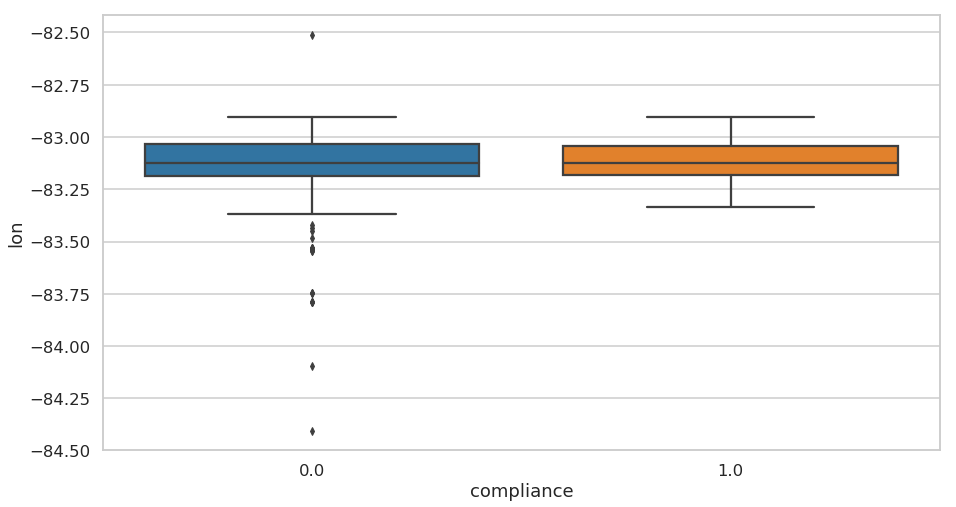

In [13]:
draw_boxplot(df, 'compliance', 'lon')

We observe that outliers have longitude below around -83.7 or above -82.6

In [14]:
# df[(df.lon < -83.7) | (df.lon > -82.6)].shape[0]

In [15]:
# draw_boxplot(df[(df.lon > -83.7) & (df.lon < -82.6)], 'compliance','lon')

In [16]:
is_outlier = (df.lat > 42.75) | (df.lon < -83.7) | (df.lon > -82.6)
"""There are {} observations that are outliers either in lat or in lon""".format(df[is_outlier].shape[0])

'There are 14 observations that are outliers either in lat or in lon'

In [17]:
# plot_address(df[~is_outlier], 'compliance')

We remove those 14 data points from df. So far, we've removed 16 data points so we don't expect this will have a serious impact in the overall distribution

In [18]:
df = df[~is_outlier]
# df.shape[0]

### Clustering lat and lon 

In [19]:
from sklearn import preprocessing

X = df[['lat', 'lon']].as_matrix()
y = df[['compliance']]

mm_scaler = preprocessing.MinMaxScaler()
X_scaled = mm_scaler.fit_transform(X)

/home/dcossao/.conda/envs/introDS/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Plot X_scaled

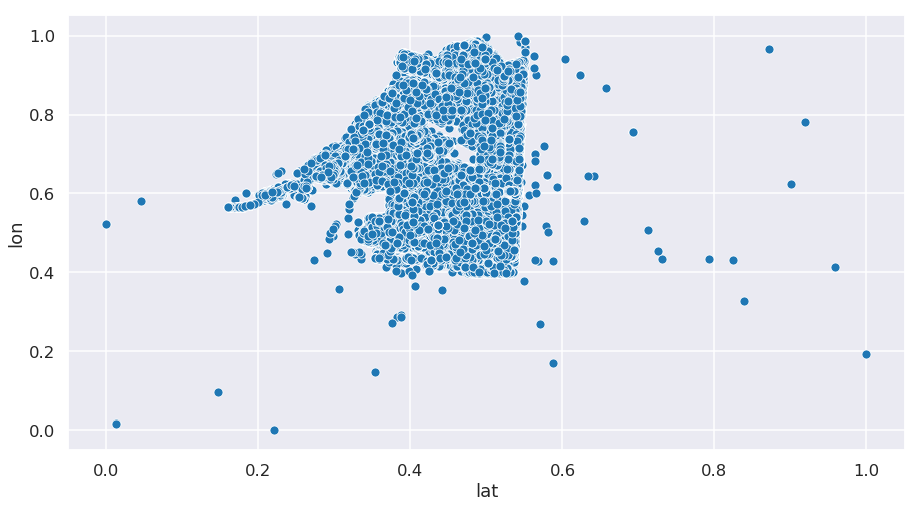

In [20]:
X_scaled_df = pd.DataFrame(X_scaled, columns=['lat', 'lon'])
plot_address(X_scaled_df)

#### K-means, k=3

In [52]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state = 0)
kmeans.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [53]:
cluster_labels = pd.DataFrame(kmeans.labels_, columns=['cluster label'])

In [55]:
result = pd.concat([X_scaled_df, cluster_labels], axis=1, join='inner')

In [61]:
cluster_compliance = pd.concat([result, y], axis=1, join = 'inner')

In [78]:
cluster_compliance.dtypes

lat              float64
lon              float64
cluster label      int32
compliance       float64
dtype: object

In [111]:
# cluster_compliance.head()

In [101]:
cluster_compliance[cluster_compliance.compliance== 1].groupby('cluster label').compliance.count()

cluster label
0    4374
1    3858
2    3364
Name: compliance, dtype: int64

In [103]:
cluster_compliance.groupby('cluster label').size()

cluster label
0    61272
1    52731
2    45845
dtype: int64

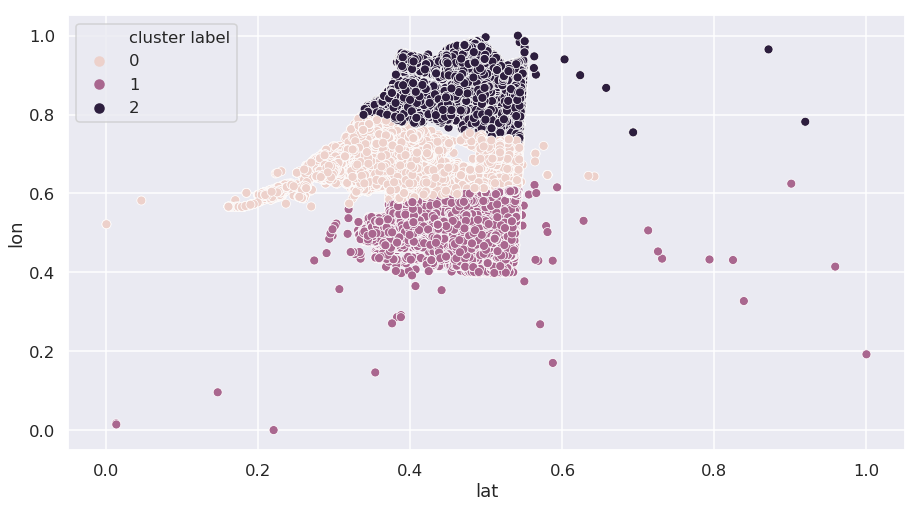

In [41]:
plot_address(result, 'cluster label')

We'd like to see what happens with clusters if we restrict more lat and lon

In [43]:
df_small = smaller(df, 42.25, 42.5, -83.4, -82.95)
# df_smaller.shape[0]

In [104]:
X_small = df_small[['lat', 'lon']].as_matrix()
y_small = df_small[['compliance']]

X_small_scaled = mm_scaler.fit_transform(X_small)

/home/dcossao/.conda/envs/introDS/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [105]:
X_small_scaled_df = pd.DataFrame(X_small_scaled, columns=['lat', 'lon'])
# plot_address(X_small_scaled_df)

In [106]:
kmeans.fit(X_small_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [107]:
small_cluster_labels = pd.DataFrame(kmeans.labels_, columns=['cluster label'])

In [108]:
small_result = pd.concat([X_small_scaled_df, small_cluster_labels], axis=1, join='inner')

In [110]:
small_result.shape[0] == y_small.shape[0]

True

In [109]:
cluster_compliance_small = pd.concat([small_result, y_small], axis=1, join = 'inner')

In [112]:
cluster_compliance_small[cluster_compliance_small.compliance== 1].groupby('cluster label').compliance.count()

cluster label
0    4532
1    3010
2    2778
Name: compliance, dtype: int64

In [113]:
cluster_compliance_small.groupby('cluster label').size()

cluster label
0    63630
1    42797
2    39122
dtype: int64

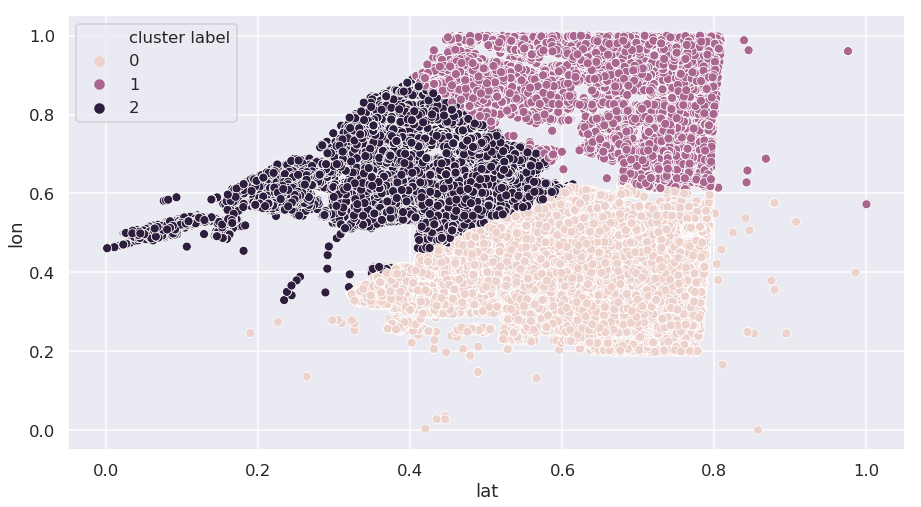

In [49]:
plot_address(small_result, 'cluster label')